In [167]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os
import json

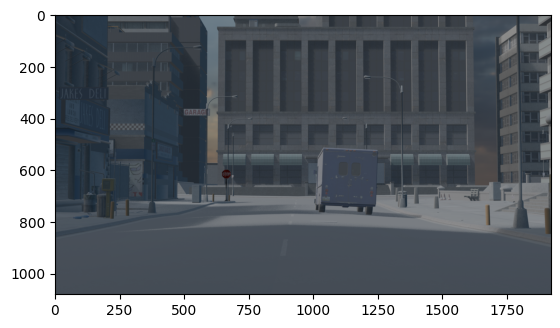

In [64]:
image_base = cv2.imread("C:\\Users\\SKG\\GitHub\\3D_ComputerVision\\blender_augmentation\\models\\data\\images\\image_001_0001.png")
image_base = cv2.cvtColor(image_base, cv2.COLOR_BGR2RGB)
plt.imshow(image_base)

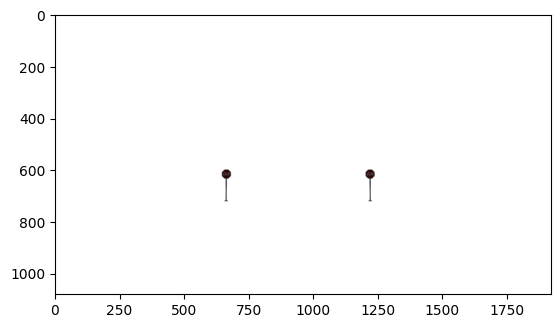

In [65]:
image_label = cv2.imread("C:\\Users\\SKG\\GitHub\\3D_ComputerVision\\blender_augmentation\\models\\data\\labels\\image_001_0001_label.png", cv2.IMREAD_UNCHANGED)
image_label = cv2.cvtColor(image_label, cv2.COLOR_BGRA2RGBA)
plt.imshow(image_label)

In [67]:
# Извлечение альфа-канала
alpha_channel = image_label[:, :, 3]
# Бинаризация маски
_, mask = cv2.threshold(alpha_channel, 1, 255, cv2.THRESH_BINARY)

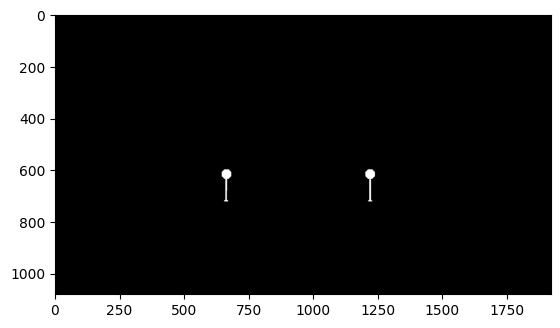

In [71]:
plt.imshow(mask, cmap='gray')

In [72]:
# Поиск контуров
contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

Euclidean Distance: 0.8010047138121289


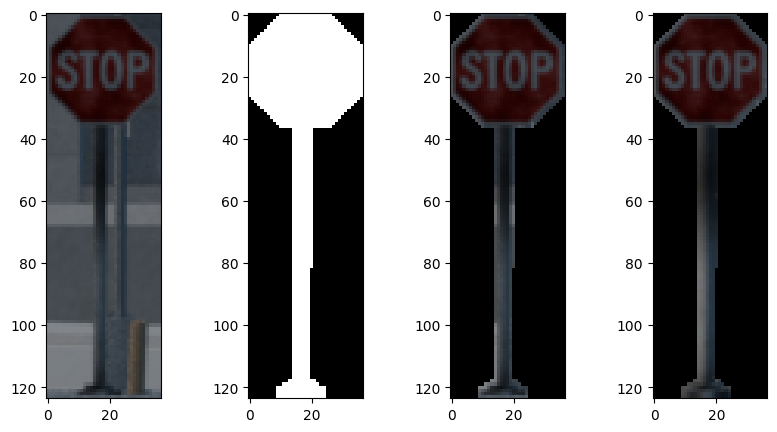

In [115]:
x, y, w, h = cv2.boundingRect(contours[1])
body = image_base[y:y+h,x:x+w]
body_label = image_label[y:y+h,x:x+w]
body_mask = mask[y:y+h,x:x+w]

masked_image = cv2.bitwise_and(body[:, :, :3], body[:, :, :3], mask=body_mask)
masked_image_label = cv2.bitwise_and(body_label[:, :, :3], body_label[:, :, :3], mask=body_mask)
mean_value_image = cv2.mean(masked_image[:, :, :3], mask=body_mask)
mean_value_label = cv2.mean(masked_image_label[:, :, :3], mask=body_mask)


# Method 1: Calculate Absolute Difference
# Method 2: Calculate Euclidean Distance
distance = np.linalg.norm(np.array(mean_value_image[:3]) - np.array(mean_value_label[:3]))
print(f"Euclidean Distance: {distance}")

fig, ax = plt.subplots(1, 4, figsize=(10, 5))
ax[0].imshow(body)
ax[1].imshow(body_mask, cmap='gray')
ax[2].imshow(masked_image, cmap='gray')
ax[3].imshow(masked_image_label, cmap='gray')


(60.964444444444446, 69.2, 85.11833333333334, 0.0)
(51.21699716713881, 40.31841359773371, 44.10084985835694, 0.0)


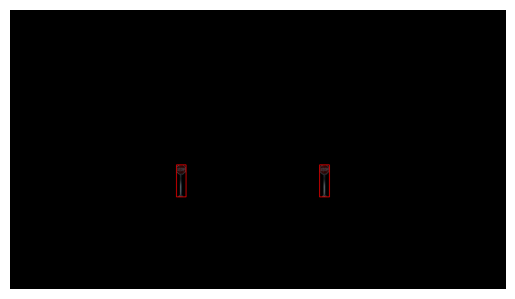

In [93]:
# Рисуем bounding box
output_image = image_label[:, :, :3].copy()  # Убираем альфа-канал

for contour in contours:
    x, y, w, h = cv2.boundingRect(contour)

    body = image_base[y:y+h,x:x+w]
    body_mask = mask[y:y+h,x:x+w]
    # Применение маски
    masked_image = cv2.bitwise_and(body[:, :, :3], body[:, :, :3], mask=body_mask)
    # Среднее значение пикселей в маске
    mean_value = cv2.mean(body[:, :, :3], mask=body_mask)
    print(mean_value)


    cv2.rectangle(output_image, (x, y), (x + w, y + h), (255, 0, 0), 2)

# Отображение результата
plt.imshow(output_image)
plt.axis('off')
plt.show()

Загрузим данные о изображениях и лейблах к ним

In [168]:
images_path = sorted(os.listdir("C:\\Users\\SKG\\GitHub\\3D_ComputerVision\\blender_augmentation\\models\\data\\images"))
labels_path = sorted(os.listdir("C:\\Users\\SKG\\GitHub\\3D_ComputerVision\\blender_augmentation\\models\\data\\labels"))

Создание словаря с данными об изображении и аннотации

In [170]:
data = {}
data["images"]=[]
data["annotations"]=[]
data["categories"]=[]
data

{'images': [], 'annotations': [], 'categories': []}

In [171]:
for i in range(len(images_path)):
    # Определение пути к файлам
    image_path = "C:\\Users\\SKG\\GitHub\\3D_ComputerVision\\blender_augmentation\\models\\data\\images\\" + images_path[i]
    label_path = "C:\\Users\\SKG\\GitHub\\3D_ComputerVision\\blender_augmentation\\models\\data\\labels\\" + labels_path[i]
    
    # Открытие файлов с cv2
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    label = cv2.imread(label_path, cv2.IMREAD_UNCHANGED)
    label = cv2.cvtColor(label, cv2.COLOR_BGRA2RGBA)

    data["images"].append({"id": i , "file_name": images_path[i], "height": image.shape[0], "width": image.shape[1]})
    data["annotations"].append({"id": [] , "image_id": [], "category_id": [], "bbox": [], "area": [], "iscrowd": []})
    data["categories"].append({"id": [], "name": []})
        

    # Извлечение альфа-канала
    alpha_channel = label[:, :, 3]
    # Бинаризация маски
    _, mask = cv2.threshold(alpha_channel, 1, 255, cv2.THRESH_BINARY)

    # Поиск контуров
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Рисуем bounding box
    output_image = image[:, :, :3].copy()  # Убираем альфа-канал

    for j, contour in enumerate(contours):
        # ---------------------------------------------------------------
        x, y, w, h = cv2.boundingRect(contour)
        body = image[y:y+h,x:x+w]
        body_label = label[y:y+h,x:x+w]
        body_mask = mask[y:y+h,x:x+w]

        masked_image = cv2.bitwise_and(body[:, :, :3], body[:, :, :3], mask=body_mask)
        masked_image_label = cv2.bitwise_and(body_label[:, :, :3], body_label[:, :, :3], mask=body_mask)
        mean_value_image = cv2.mean(masked_image[:, :, :3], mask=body_mask)
        mean_value_label = cv2.mean(masked_image_label[:, :, :3], mask=body_mask)

        distance = np.linalg.norm(np.array(mean_value_image[:3]) - np.array(mean_value_label[:3]))
        
        if distance < 10:
            data["annotations"][i]["id"].append(j)
            data["annotations"][i]["image_id"].append(i)
            data["annotations"][i]["category_id"].append(0)
            data["annotations"][i]["bbox"].append([x, y, w, h])
            data["annotations"][i]["area"].append(w * h)
            data["annotations"][i]["iscrowd"].append(0)
        
            data["categories"][i]["id"].append(j)
            data["categories"][i]["name"].append("stop_sign")

        
        # ---------------------------------------------------------------



In [172]:
# Сохранение в файл
with open("annotations.json", "w") as f:
    json.dump(data, f, indent=4)

Проверка работоспособности аннотации

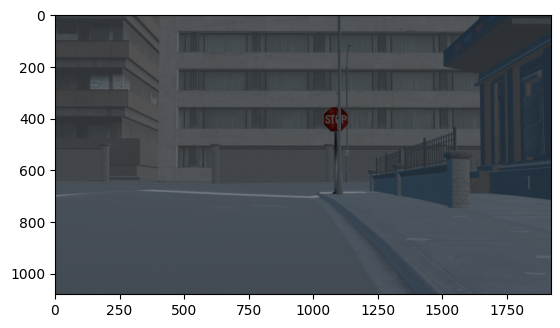

In [191]:
im_path = data["images"][56]["file_name"]
image_path = "C:\\Users\\SKG\\GitHub\\3D_ComputerVision\\blender_augmentation\\models\\data\\images\\" + im_path
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image)

In [192]:
bboxs = data["annotations"][56]["bbox"]
output_image = image.copy()

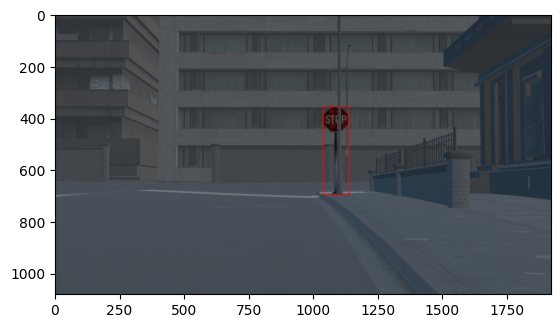

In [193]:
for x,y,w,h in bboxs:
    cv2.rectangle(output_image, (x, y), (x + w, y + h), (255, 0, 0), 2)

plt.imshow(output_image)
plt.show()

